# Exploratory Data Analysis (EDA) for CLIPSeg Dataset

## Introduction
This notebook presents an in-depth analysis of the CLIPSeg dataset, comprising approximately 17,000 records. The goal is to understand the dataset's characteristics, identify potential biases, and derive insights for enhancing the performance of the CLIPSeg model for segmenting clothing better.

## 1. Loading the Dataset and Initial Counts

Understand the overall structure of the dataset and obtain basic statistics.
Understanding the dataset's structure and class distribution is crucial for identifying potential imbalances and biases. This step sets the stage for subsequent analyses and interventions, like data augmentation, to ensure the model learns from a well-rounded representation of data.

In [1]:
from datasets import load_dataset

dataset_name = "mattmdjaga/human_parsing_dataset"
train_dataset = load_dataset(dataset_name, split="train")


In [2]:
print("Total Dataset Size:", len(train_dataset))

Total Dataset Size: 17706


In [3]:
print("Dataset columns:", [x for x in train_dataset[0].keys()])

Dataset columns: ['image', 'mask']


## 2. Sample a few images and mask for visualization

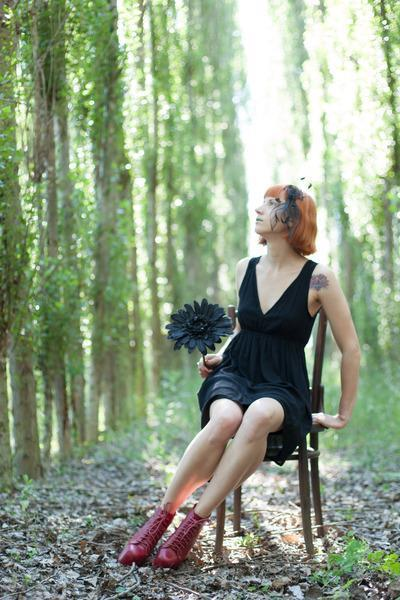

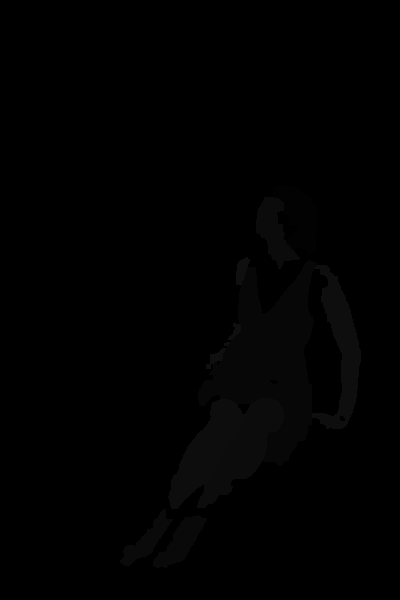

(None, None)

In [4]:


import random

# set seed
random.seed(20)

# sample an image and mask pair and visualize data
pair = random.choice(train_dataset)

display(pair["image"]), display(pair["mask"])

In [5]:
import numpy as np
from PIL import Image
image = pair["image"]
np_mask = np.array(pair["mask"])
print("Image shape:", np_mask.shape)
print("Mask shape:", np_mask.shape)
print("Mask values", np.unique(np_mask))

Image shape: (600, 400)
Mask shape: (600, 400)
Mask values [ 0  2  7  9 10 11 12 13 14 15]


## 3. Instance Frequency Analysis
This analysis highlights the necessity for data augmentation, especially for underrepresented classes, to prevent model biases and improve the model's ability to recognize less common clothing items and accessories.

In [ ]:
mask_map_dict = {
    "0": "Background",
    "1": "Hat",
    "2": "Hair",
    "3": "Sunglasses",
    "4": "Upper-clothes",
    "5": "Skirt",
    "6": "Pants",
    "7": "Dress",
    "8": "Belt",
    "9": "Left-shoe",
    "10": "Right-shoe",
    "11": "Face",
    "12": "Left-leg",
    "13": "Right-leg",
    "14": "Left-arm",
    "15": "Right-arm",
    "16": "Bag",
    "17": "Scarf"
}
color_map_dict = {
    "0": (0, 0, 0, 128),  # Background, fully transparent
    "1": (255, 0, 0, 128),  # Hat, red
    "2": (255, 165, 0, 128),  # Hair, orange
    "3": (255, 255, 0, 128),  # Sunglasses, yellow
    "4": (0, 128, 0, 128),  # Upper-clothes, green
    "5": (0, 0, 255, 128),  # Skirt, blue
    "6": (75, 0, 130, 128),  # Pants, indigo
    "7": (238, 130, 238, 128),  # Dress, violet
    "8": (255, 192, 203, 128),  # Belt, pink
    "9": (139, 69, 19, 128),  # Left-shoe, brown
    "10": (255, 245, 238, 128),  # Right-shoe, seashell
    "11": (255, 228, 225, 128),  # Face, misty rose
    "12": (0, 255, 255, 128),  # Left-leg, cyan
    "13": (72, 209, 204, 128),  # Right-leg, medium turquoise
    "14": (173, 216, 230, 128),  # Left-arm, light blue
    "15": (32, 178, 170, 128),  # Right-arm, light sea green
    "16": (47, 79, 79, 128),  # Bag, dark slate grey
    "17": (70, 130, 180, 128)  # Scarf, steel blue
}

In [9]:
# Filter through the dataset to get number of instances for each class
label_instances = {}
for pair in train_dataset:
    np_mask_unique = np.unique(np.array(pair["mask"]))
    for label in np_mask_unique:
        if mask_map_dict[str(label)] in label_instances.keys():
            temp = label_instances[mask_map_dict[str(label)]]
            label_instances[mask_map_dict[str(label)]] = temp+1
        else:
            label_instances[mask_map_dict[str(label)]] = 1

In [40]:
# instances for each class in the dataset
for key, val in label_instances.items():
    print(key, val)

Background 17706
Hair 17476
Dress 4644
Belt 2548
Left-shoe 14972
Right-shoe 14964
Face 17651
Left-leg 11334
Right-leg 11319
Left-arm 15884
Right-arm 15790
Bag 9301
Upper-clothes 14923
Skirt 4928
Hat 3684
Sunglasses 5054
Pants 10132
Scarf 1000


## 4. Visual Inspection of Masks
Visual inspection helps in identifying inaccuracies in segmentation masks. Preprocessing steps like morphological operations can be devised to refine these masks, enhancing model training effectiveness and segmentation accuracy.

In [7]:
# helper function to create better visualisation to see the mask 
def create_overlay_mask(image, mask, color_map_dict):
    """
    Create an overlay mask on the original image.
    
    Parameters:
    - image: original PIL image.
    - mask: 2D numpy array with each pixel's value representing the segment label.
    - color_map_dict: dictionary mapping segment labels to RGBA values.
    
    Returns:
    - An Image object with the overlay mask applied.
    """
    # Load the original image
    image = image.convert("RGBA")  # Ensure image is in RGBA format
    
    # Create an empty RGBA image for the mask
    overlay = Image.new("RGBA", image.size, (0, 0, 0, 0))
    
    
    # For each unique label in the mask, apply the corresponding color and alpha
    for label in np.unique(mask):
        
        # Create a mask for the current label
        label_mask = np.where(mask == label, 255, 0).astype('uint8')
        
        # Convert the label mask to an RGBA image where the label pixels have the color and alpha from the color map
        label_color = Image.new("RGBA", image.size, color_map_dict[str(label)])
        
        # Create a mask image from the label mask
        label_mask_image = Image.fromarray(label_mask, mode='L')
        
        # Composite the colored label image onto the overlay image using the label mask as the mask
        overlay = Image.composite(label_color, overlay, label_mask_image)
    
    # Composite the overlay onto the original image
    combined = Image.alpha_composite(image, overlay)
    
    return combined

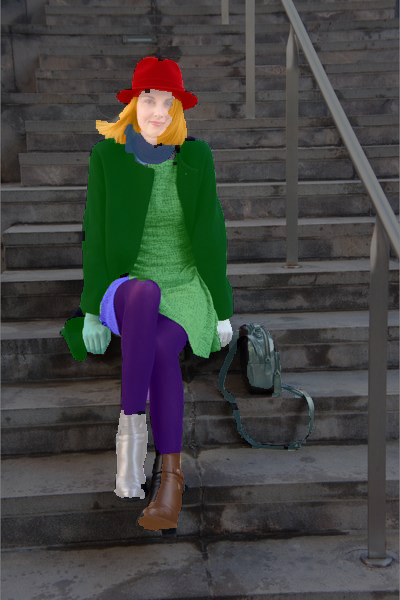

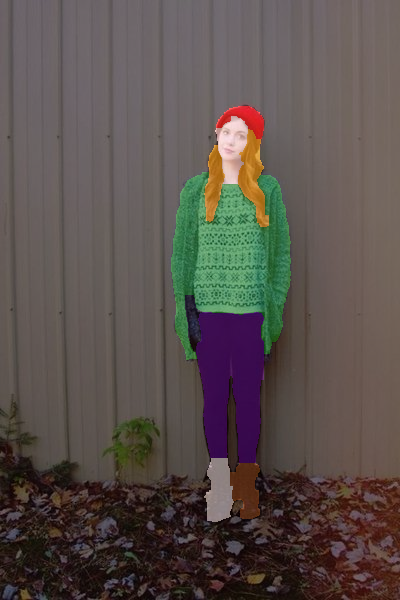

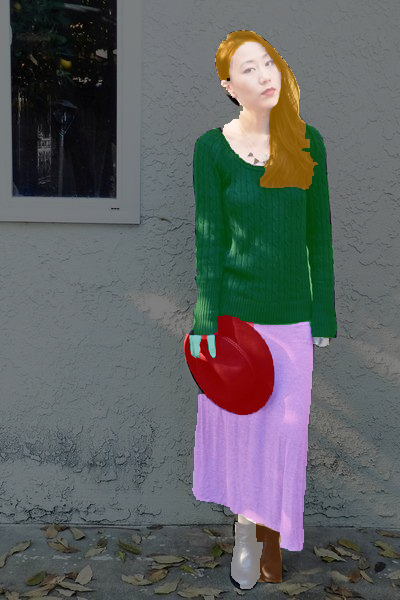

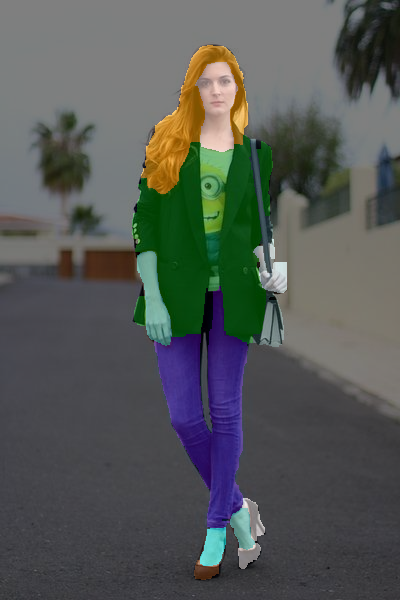

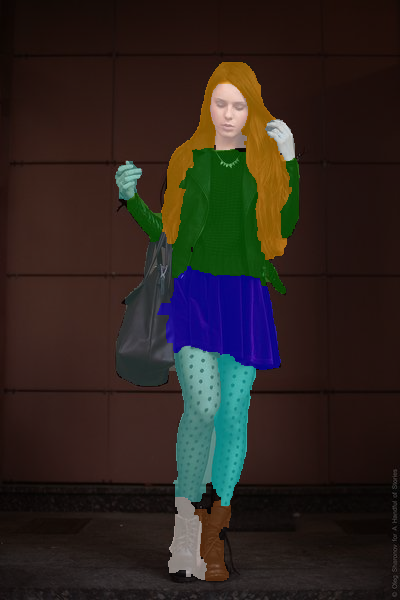

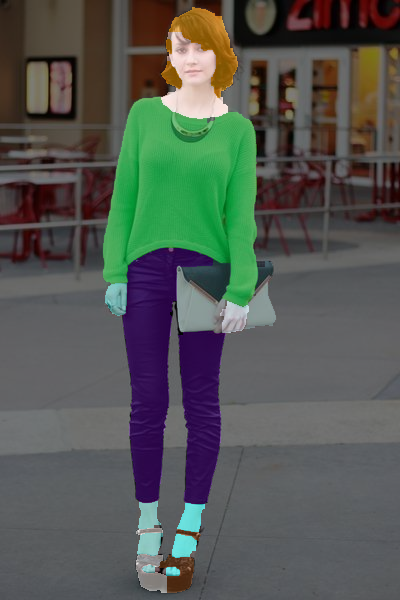

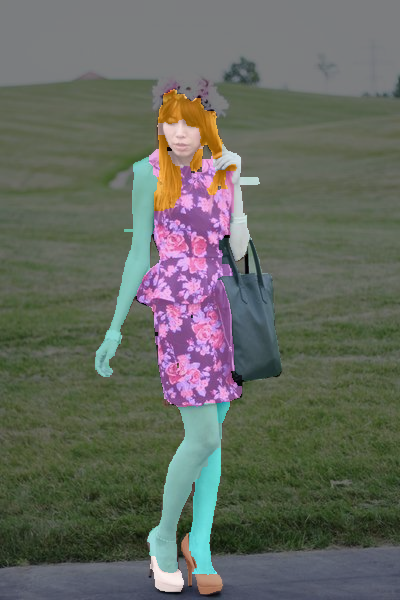

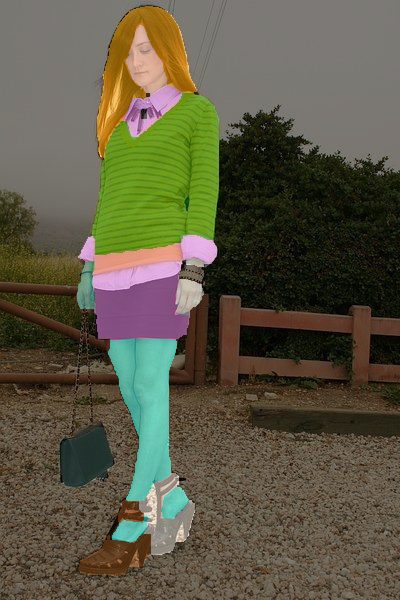

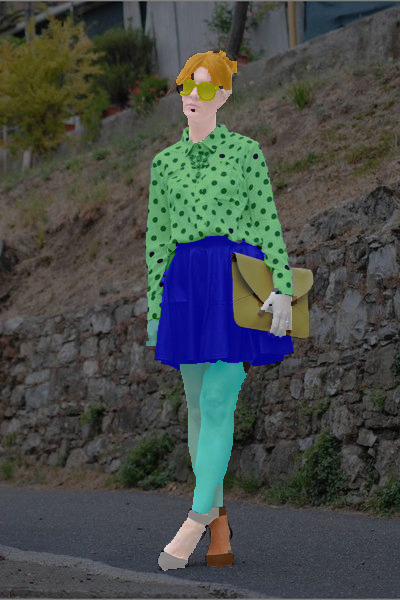

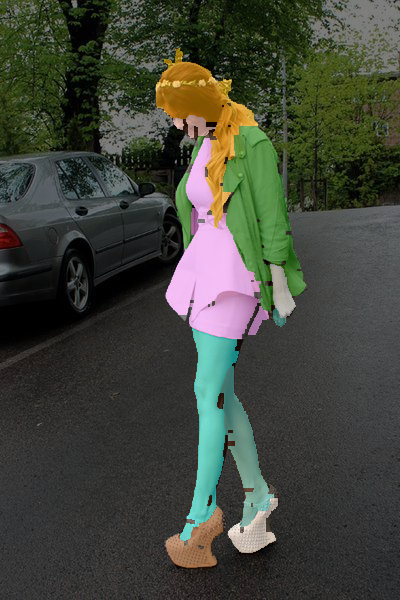

In [8]:
random_choices = random.choices(train_dataset, k=10)
for pair in random_choices:
    image = pair["image"]
    np_mask = np.array(pair["mask"])
    comb = create_overlay_mask(image,np_mask, color_map_dict)
    display(comb)

## 5. Mask Correlation Analysis
Investigating correlations between different classes within the masks to understand common co-occurrences, can guide data augmentation choices.Understanding mask correlations enables us to simulate realistic scenarios through data augmentation, such as the co-occurrence of certain clothing items, improving the model's contextual understanding.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_class_presence_vector(mask, n_classes):
    """
    Create a binary class presence vector for a given mask.
    
    Parameters:
    - mask: 2D numpy array, where each element is a class label for the pixel.
    - n_classes: int, total number of classes.
    
    Returns:
    - A binary vector indicating the presence (1) or absence (0) of each class in the mask.
    """
    class_presence = np.zeros(n_classes, dtype=int)
    unique_classes = np.unique(mask)
    class_presence[unique_classes] = 1
    return class_presence

# Example masks loading
# Assuming masks is a list of 2D numpy arrays representing the class labels for each pixel in each image
n_classes = 18  # Total number of classes
class_presence_vectors = []

for pair in train_dataset:
    mask = np.array(pair["mask"])
    class_presence_vector = create_class_presence_vector(mask, n_classes)
    class_presence_vectors.append(class_presence_vector)

# Now, let's proceed with the co-occurrence and correlation calculation as before
co_occurrence_matrix = np.zeros((n_classes, n_classes))

for vector in class_presence_vectors:
    for i in range(n_classes):
        for j in range(n_classes):
            if vector[i] == 1 and vector[j] == 1:
                co_occurrence_matrix[i, j] += 1

# Normalize the co-occurrence matrix
co_occurrence_matrix /= len(class_presence_vectors)

# Calculating the Pearson correlation coefficient matrix
correlation_matrix = np.corrcoef(co_occurrence_matrix)


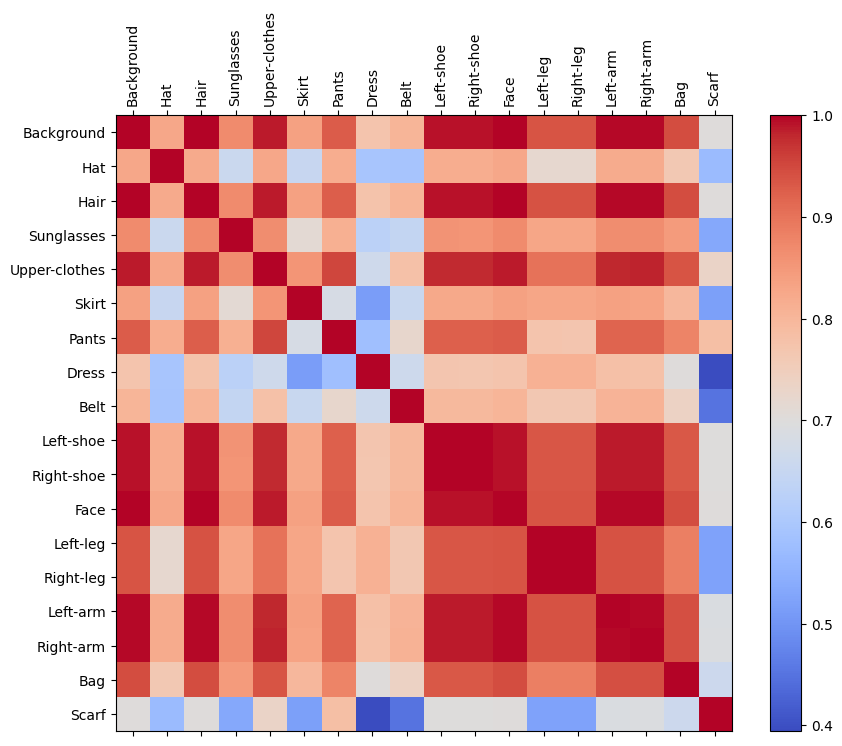

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

# Create a list of names in the order corresponding to your correlation matrix's indices
names = [mask_map_dict[str(i)] for i in range(n_classes)]

# Create the heatmap
cax = ax.matshow(correlation_matrix, cmap='coolwarm')

# Set tick labels
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)

# Add color bar
fig.colorbar(cax)

plt.show()

## 6. Spatial Heatmap Analysis
Analyzing the spatial distribution of each class to uncover any positional biases in the dataset. This analysis reveals spatial biases in class occurrences, indicating the need for background replacement and varied positioning of objects through data augmentation. It ensures the model learns to recognize classes across different spatial contexts.

In [34]:
# Define your heatmap size (e.g., 100x100 grid for simplicity)
heatmap_size = (40, 60) # Adjust based on desired granularity
# Initialize a heatmap for each class
class_heatmaps = {class_id: np.zeros(heatmap_size) for class_id in range(18)} # Assuming 18 classes

In [35]:
import cv2
def update_heatmap_for_batch(pair, class_heatmaps):
    image = np.array(pair["image"])
    mask = np.array(pair["mask"])
    for class_id in class_heatmaps:
        # Create a mask for the current class
        class_mask = (mask == class_id)
        
        # Summarize this mask into the heatmap grid
        # Resize class mask to heatmap size (consider using cv2.resize for efficiency)
        resized_mask = cv2.resize(class_mask.astype(np.float32), (heatmap_size[1], heatmap_size[0]), interpolation=cv2.INTER_NEAREST)
        
        # Update the class heatmap
        class_heatmaps[class_id] += resized_mask
    return class_heatmaps


In [36]:
for pair in train_dataset:
    update_heatmap_for_batch(pair, class_heatmaps)

In [37]:
# Normalize heatmaps (example: convert counts to proportions)
for class_id in class_heatmaps:
    class_heatmaps[class_id] /= label_instances[mask_map_dict[str(class_id)]]

In [38]:
def visualize_class_heatmap(class_heatmaps, class_names, figsize=(10, 8)):
    """
    Visualizes class heatmaps.
    
    Parameters:
    - class_heatmaps: Dict of 2D numpy arrays, keys are class IDs, values are heatmaps.
    - class_names: Dict of class IDs to human-readable names.
    - figsize: Tuple indicating figure size.
    """
    n_classes = len(class_heatmaps)
    cols = 3  # Define how many columns you want in the plot
    rows = np.ceil(n_classes / cols)  # Calculate required number of rows
    
    fig, axes = plt.subplots(int(rows), int(cols), figsize=figsize)
    axes = axes.flatten()  # Flatten the matrix of axes to easily iterate over
    
    for idx, (class_id, heatmap) in enumerate(class_heatmaps.items()):
        ax = axes[idx]
        sns.heatmap(heatmap, ax=ax, cmap="viridis")
        ax.set_title(class_names[str(class_id)])
        ax.axis('off')  # Hide axes ticks
        
    for idx in range(len(class_heatmaps), len(axes)):
        axes[idx].axis('off')  # Hide unused subplots
    
    plt.tight_layout()
    plt.show()

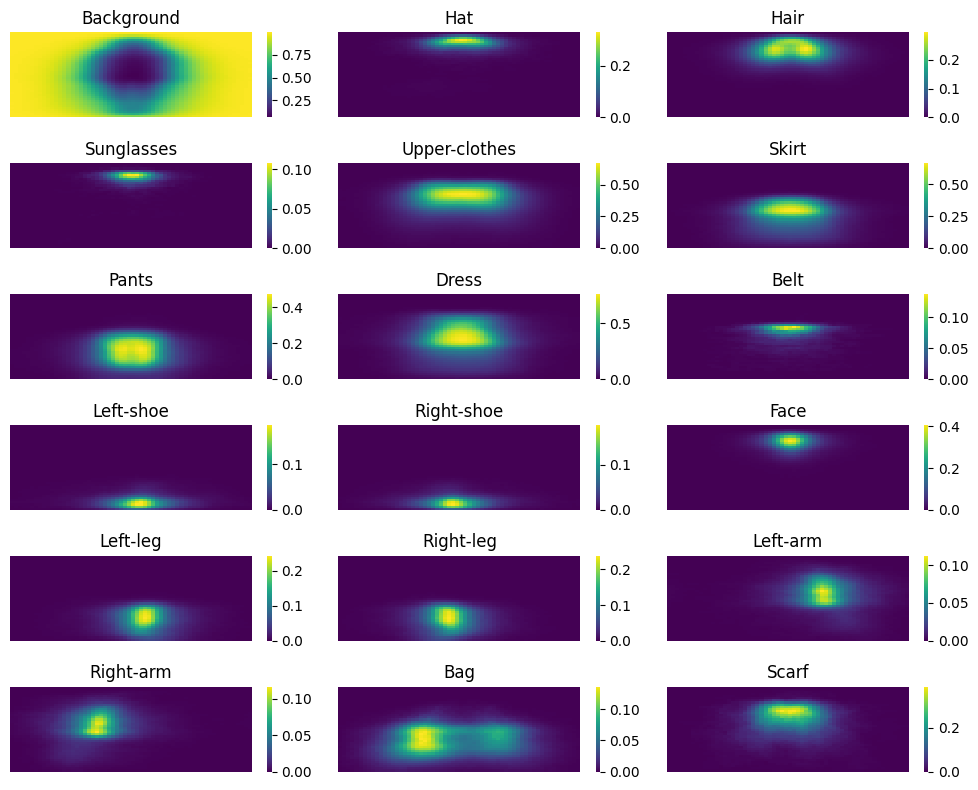

In [39]:
visualize_class_heatmap(class_heatmaps, mask_map_dict)

## 7. Conclusion and Strategy for Model Improvement
The EDA conducted reveals critical insights into the dataset's characteristics, including class imbalances, spatial biases, and class co-occurrences. To address these findings, we propose a comprehensive data augmentation strategy involving:

1. Augmenting rare classes to balance class frequency, ensuring the model learns from a diverse set of examples for each class.
2. Applying morphological operations on masks to improve segmentation accuracy, particularly for classes with intricate boundaries.
3. Simulating varied backgrounds and object positions to mitigate spatial biases and improve the model's robustness to different contexts.
4. Generating realistic scenarios based on mask correlation analysis to enhance the model's contextual understanding of class co-occurrences.

Through targeted data augmentation and preprocessing, we aim to enhance the CLIPSeg model's performance, making it more adept at capturing the finer details of clothing and accessories in human parsing tasks.